# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.895613,False,0.032257
1,-0.622533,False,-1.312021
2,-0.644899,False,0.757557
3,1.765545,True,5.356255
4,0.704589,False,0.917552
...,...,...,...
995,1.267934,True,3.880754
996,2.654832,True,3.932898
997,1.339011,True,7.140855
998,2.148516,True,5.773133


<AxesSubplot:xlabel='v0'>

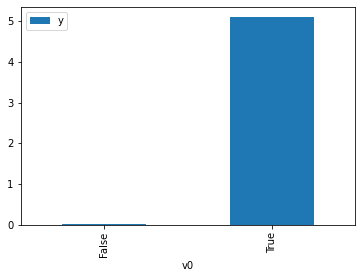

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

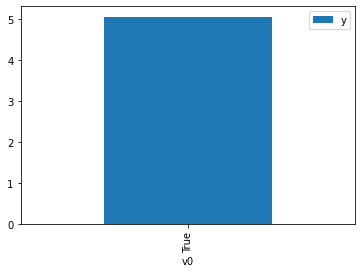

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.130365,False,0.440583,0.198257,5.043948
1,1.133280,False,-0.751090,0.197654,5.059344
2,0.154514,False,-1.052808,0.468818,2.133026
3,-0.801882,False,-0.216365,0.754373,1.325604
4,-2.659556,False,0.895378,0.971918,1.028894
...,...,...,...,...,...
995,0.619895,False,0.251488,0.324830,3.078533
996,0.858651,False,0.427064,0.260580,3.837591
997,0.704589,False,0.917552,0.301095,3.321209
998,2.230778,False,0.511255,0.055622,17.978639


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.208642,True,3.571498,0.413723,2.417077
1,0.292691,True,6.220223,0.575676,1.737087
2,0.444647,True,4.967821,0.623204,1.604610
3,-0.183139,True,6.234874,0.421810,2.370733
4,0.983309,True,5.511330,0.769500,1.299546
...,...,...,...,...,...
995,0.444929,True,3.441169,0.623291,1.604388
996,1.472040,True,5.534681,0.863268,1.158389
997,-0.235321,True,3.373979,0.405312,2.467238
998,0.340457,True,5.381418,0.590813,1.692583


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              8029.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        21:23:42   Log-Likelihood:                         -1408.9
No. Observations:                1000   AIC:                                      2822.
Df Residuals:                     998   BIC:                                      2832.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0926      0.035      2.630      0.009       0.023       0.162
x2             4.9854      0.052     96.557      0.000       4.884       5.087
==============================================================================
Omnibus:                        0.845   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.893
Skew:                           0.068   Prob(JB):                        0.640
Kurtosis:                       2.948   Cond. No.                         2.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""